# This kernel has two purposes:
1. Compare and select models from Simpler Regresiion, Lasso, Ridge and Elastic Net
2. use cross validation to prevent overfitting.
Credit: Some of the scripts in this kernel follows a notebook https://www.kaggle.com/apapiu/regularized-linear-models  by  Alexandru Papiu (@apapiu, GitHub) 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
#Read the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.tail()


['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,...,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,...,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [2]:
#concatenate train and test
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']])

In [3]:
from scipy.stats import skew

def num_cat_separate(df):
    """
    seperate features into numerica and categorical features based on dtypes
    return: df of column names
    -------
    df: DataFrame, contains columns of numeric and categorical data
    """
    nuemric_features = df.dtypes[all_data.dtypes !='object']
    categorical_features = all_data.dtypes[all_data.dtypes =='object']
    return nuemric_features, categorical_features

def remove_skewness(df,features_to_check ,threshold=None):
    """
    log1p transform the skewed featrues if the skewness is greater than sk_threshold
    """
    df_copy = df.copy()
    transformed_feats = df[features_to_check].apply(lambda x: skew(x.dropna()))
    if threshold is not None:
        transformed_feats = transformed_feats[transformed_feats > threshold]
    transformed_feats = transformed_feats.index
    
    print(f'The features that are log1p transformed, with threshold = {threshold}: {transformed_feats}')
    df_copy[transformed_feats] = np.log1p(df[transformed_feats])
    return df_copy
    

def normalize(df):
    df_stats = df.describe()
    df_stats = df_stats.transpose()
    normed_df = (df-df_stats.loc[:,'mean']) /df_stats.loc[:,'std']
    return normed_df
def error(actual, hat):
    return np.sqrt(np.sum(np.square(np.log(actual)-np.log(hat)))/len(actual))


In [4]:
#separate numeric, categorical features
numeric_features, categorical_features = num_cat_separate(all_data)

#set categorical data into dummy
all_data = pd.get_dummies(all_data)

#log transform to remove skewness
all_data = remove_skewness(all_data, numeric_features.index,threshold=.75)

#fill missing data with their mean
all_data = all_data.fillna(all_data.mean())

#prepare data for learning
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y=train.SalePrice
y_log = np.log1p(y)

#normalize the data
normed_all_data = normalize(all_data)
normed_X_train = normed_all_data[:train.shape[0]]
normed_X_test = normed_all_data[train.shape[0]:]


The features that are log1p transformed, with threshold = 0.75: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


# Models
 # Now we are going to evaluate a few regularized linear models
## 1. We start with Ridge 

In [5]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso,LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [6]:
def rmse_cv(model,X_train,y, **kwargs):
    rmse = np.sqrt(-cross_val_score(model, X_train,y,scoring='neg_mean_squared_error',**kwargs))
    return rmse
#rmse_cv = [  for alpha in alphas]

In [7]:
model_ridge = Ridge()
alphas = np.logspace(.5,1.5,20)

cv_ridge = [ rmse_cv(Ridge(alpha = alpha), X_train,y_log,cv=5).mean() for alpha in alphas]

10.624678    0.127166
dtype: float64

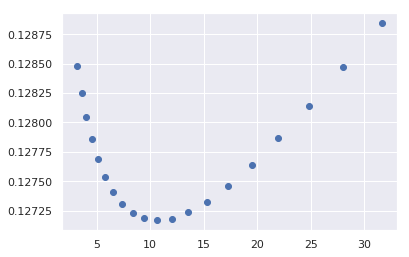

In [8]:
cv_r = pd.Series(cv_ridge, index= alphas)
sns.set()
plt.plot(cv_r,'bo')
cv_r[cv_r==cv_r.min()]

In [9]:
#finer search of alpha
alpha = cv_r[cv_r==cv_r.min()].index.values[0]
alphas =np.linspace(.9*alpha,1.1*alpha,50)

cv_ridge = [ rmse_cv(Ridge(alpha = alpha), X_train,y_log,cv=5).mean() for alpha in alphas]
cv_r = pd.Series(cv_ridge, index= alphas)



the optimal result for RidgeCV is (alpha, error )= ( 10.646361    0.127166
dtype: float64 )


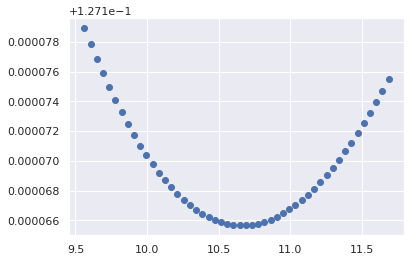

In [10]:
plt.plot(cv_r,'bo')
print('the optimal result for RidgeCV is (alpha, error )= (',cv_r[cv_r==cv_r.min()],')')
#print(alpha, rmlse)

In [11]:
alpha = cv_r[cv_r==cv_r.min()].index.values[0]
print('alpha=' ,alpha)
model_Ridge = Ridge(alpha).fit(X_train,y_log)
y_hat = np.exp(model_Ridge.predict(X_train))
print('The error of Ridege on the training set is:',error(y,y_hat))

alpha= 10.64636132589743
The error of Ridege on the training set is: 0.10596941276797917


Text(0.5,1,'Coefficients in the Ridge Model')

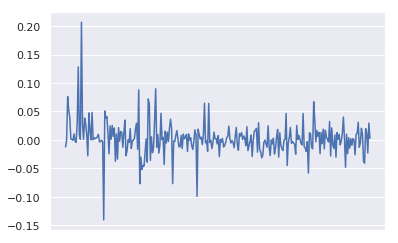

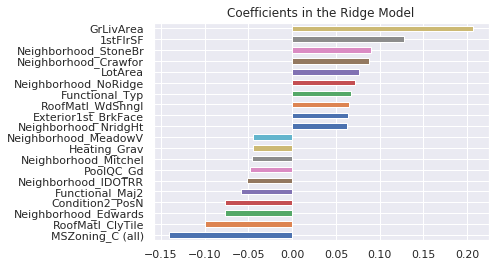

In [12]:
#visualize the coefficients and the most important ones
Ridge_coef = pd.Series(model_Ridge.coef_, index = X_train.columns)
plt.plot(Ridge_coef)
plt.xticks([])

imp_coef = pd.concat([Ridge_coef.sort_values().head(10),
                     Ridge_coef.sort_values().tail(10)])

plt.figure()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

Text(0.5,1,'Rediduals of Simple Regression')

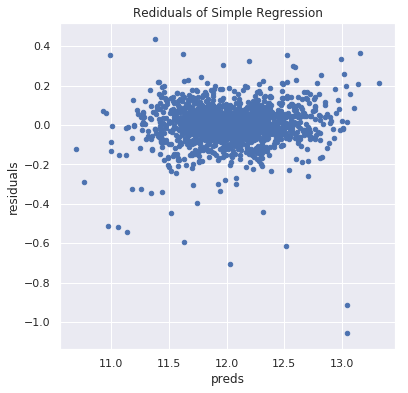

In [13]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_Ridge.predict(X_train), "true":y_log})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title('Rediduals of Simple Regression')

In [14]:
#submit the prediction
test_predictions = model_Ridge.predict(X_test)
test_predictions = np.exp(test_predictions)

submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = test_predictions
submission.to_csv('submission_Ridge.csv',index=False)

# Trying out Lasso

[1.00000000e-05 1.27427499e-05 1.62377674e-05 2.06913808e-05
 2.63665090e-05 3.35981829e-05 4.28133240e-05 5.45559478e-05
 6.95192796e-05 8.85866790e-05 1.12883789e-04 1.43844989e-04
 1.83298071e-04 2.33572147e-04 2.97635144e-04 3.79269019e-04
 4.83293024e-04 6.15848211e-04 7.84759970e-04 1.00000000e-03]


0.000483    0.122567
dtype: float64

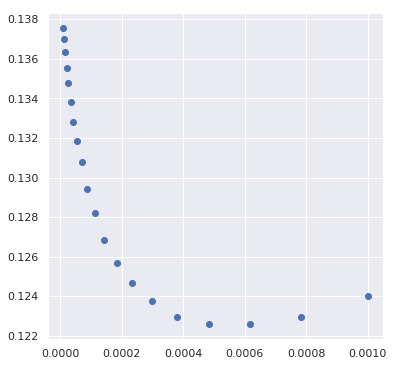

In [15]:
alphas = np.logspace(-5,-3, num=20)
print(alphas)

cv_lasso = [ rmse_cv(Lasso(alpha = alpha,max_iter=10000), X_train,y_log,cv=5).mean() for alpha in alphas]
cv = pd.Series(cv_lasso, index= alphas)
sns.set()
plt.plot(cv,'bo')
cv[cv==cv.min()]

## Here we fine tune the alpha in a linear neighborhood of optimized cv, we take $\pm$25%

In [16]:
#fine tune the alpha for LassoCV
alpha =  cv[cv==cv.min()].index.values[0]
alphas =np.linspace(.75*alpha,1.25*alpha,10)

model_LassoCV = LassoCV(alphas=alphas, max_iter=10000, cv=5 )
model_LassoCV = model_LassoCV.fit(X_train,y_log)
rmse_cv(model_LassoCV,X_train=X_train,y=y_log,cv=5).mean()
#print(alpha, rmlse)

0.12296478933398854

In [17]:
# #An alternative is to use LassoLarsCV


# model_LassoLarsCV = LassoLarsCV(max_iter=1000, cv=5 )
# model_LassoLarsCV = model_LassoLarsCV.fit(X_train,y_log)
# rmse_cv(model_LassoLarsCV,X_train=X_train,y=y_log,cv=5).mean()
# #print(alpha, rmlse)

In [18]:
#show the rms logrithmic errors
def error(actual, hat):
    return np.sqrt(np.sum(np.square(np.log(actual)-np.log(hat)))/len(actual))
train_predictions = model_LassoCV.predict(X_train)
error(y,np.exp(train_predictions))

0.10574403527855566

In [19]:
LassoCV_coef = pd.Series(model_LassoCV.coef_, index = X_train.columns)
print("LassoCV picked " + str(sum(LassoCV_coef != 0)) + " variables and eliminated the other " +  str(sum(LassoCV_coef == 0)) + " variables")


LassoCV picked 105 variables and eliminated the other 183 variables


In [20]:
imp_coef = pd.concat([LassoCV_coef.sort_values().head(10),
                     LassoCV_coef.sort_values().tail(10)])


Text(0.5,1,'Coefficients in the Lasso Model')

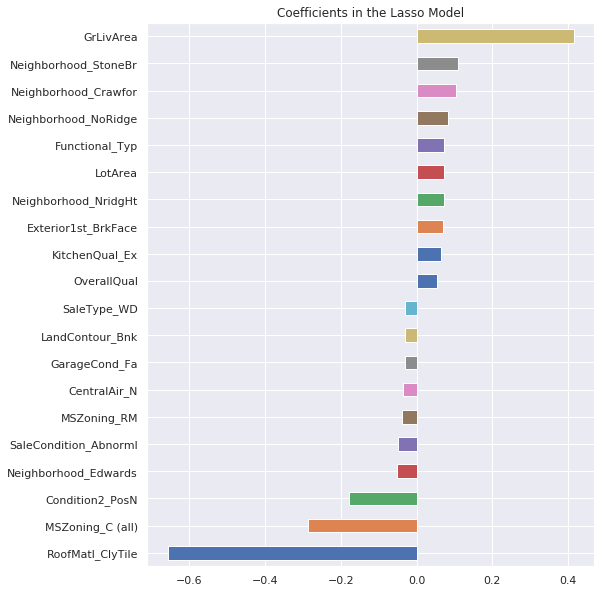

In [21]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

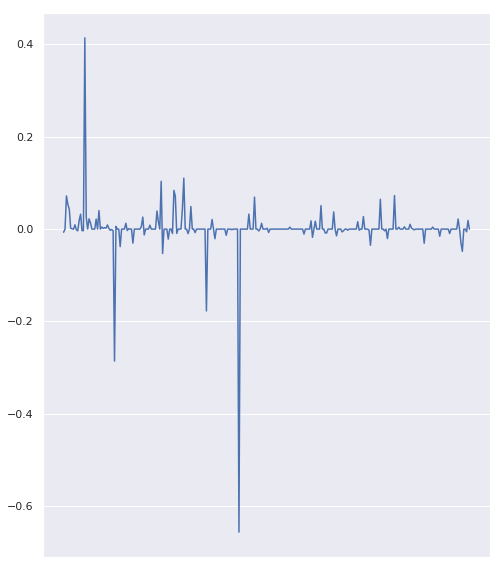

In [22]:
plt.plot(LassoCV_coef)
plt.xticks([]);

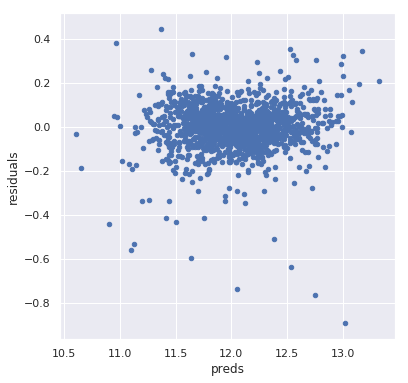

In [23]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_LassoCV.predict(X_train), "true":y_log})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Make the predictions and submit

In [24]:
#submit the prediction
test_predictions = model_LassoCV.predict(X_test)
test_predictions = np.exp(test_predictions)

submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = test_predictions
submission.to_csv('submission_LassoCV.csv',index=False)

# Try simple regression

In [25]:
from sklearn.linear_model import LinearRegression

model_reg = LinearRegression()
cv_reg = rmse_cv(model_reg, X_train, y_log, cv = 5)
print('The cv rmlse of simple regression is: ',cv_reg)


model_reg.fit(X_train,y_log)
reg_preds = model_reg.predict(X_train)
print('rmlse of simple reg on the training set is: ',error(np.exp(reg_preds), y))

The cv rmlse of simple regression is:  [0.1243231  0.14764014 0.27978484 0.11376763 0.15936848]
rmlse of simple reg on the training set is:  0.09166296185576613


Text(0.5,1,'Coefficients in the Simple Regression Model')

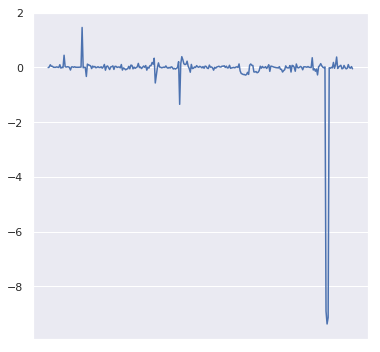

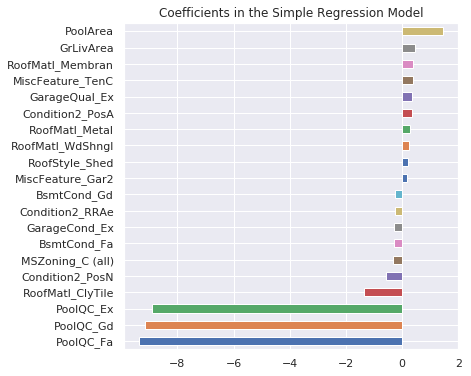

In [26]:
reg_coef = pd.Series(model_reg.coef_, index = X_train.columns)
plt.plot(reg_coef)
plt.xticks([])

imp_coef = pd.concat([reg_coef.sort_values().head(10),
                     reg_coef.sort_values().tail(10)])

plt.figure()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Simple Regression Model")

Text(0.5,1,'Rediduals of Simple Regression')

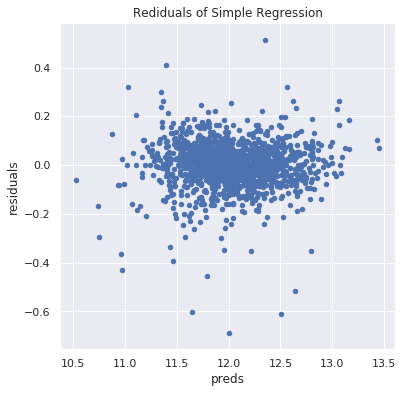

In [27]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_reg.predict(X_train), "true":y_log})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title('Rediduals of Simple Regression')

In [28]:
#submit the prediction with Simple Regression
test_predictions = model_reg.predict(X_test)
test_predictions = np.exp(test_predictions)

submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = test_predictions
submission.to_csv('submission_Regression.csv',index=False)

# Trying out Elastic Net

In [29]:
from sklearn.linear_model import ElasticNet,ElasticNetCV
l1_ratios =np.linspace(0,1,11)
alphas = np.logspace(-5,-2,10)

cv_ElasticNet = [
    [rmse_cv(ElasticNet(alpha=alpha, l1_ratio= l1_ratio), X_train,y_log,cv=5).mean() for alpha in alphas] 
                 for l1_ratio in l1_ratios]
cv = pd.DataFrame(cv_ElasticNet, index= l1_ratios, columns= alphas)
# sns.set()
# plt.plot(cv,'bo')
# cv[cv==cv.min()]




# model_ElasticNetCV = ElasticNetCV( l1_ratio=.5, cv=5)
# model_ElasticNetCV.fit(X_train, y_log)
# mse_path = model_ElasticNetCV.mse_path_


#print(mse_path)

# cv_ElasticNet = [ rmse_cv(model_ElasticNetCV, X_train,y_log,cv=5).mean() for alpha in alphas]
# cv = pd.Series(cv_ElasticNet, index= alphas)
# sns.set()
# plt.plot(cv,'bo')
# cv[cv==cv.min()]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [30]:
cv_t = cv.transpose()
cv_t

,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
0.000010,0.140148,0.139506,0.138908,0.138469,0.138350,0.138199,0.138044,0.137893,0.137708,0.137486,0.137154
0.000022,0.139681,0.138921,0.138167,0.137618,0.137364,0.137040,0.136732,0.136436,0.136140,0.135752,0.135365
0.000046,0.138786,0.137753,0.136749,0.135905,0.135334,0.134813,0.134352,0.133841,0.133371,0.132930,0.132510
0.000100,0.137407,0.135820,0.134319,0.133168,0.132261,0.131532,0.130908,0.130317,0.129715,0.129236,0.128853
0.000215,0.135488,0.133013,0.131036,0.129636,0.128427,0.127584,0.126761,0.126136,0.125657,0.125287,0.124998
0.000464,0.133186,0.129758,0.127381,0.125882,0.124853,0.124200,0.123691,0.123247,0.122923,0.122708,0.122599
0.001000,0.130880,0.126663,0.124567,0.123608,0.123124,0.122881,0.122870,0.122982,0.123208,0.123588,0.124011
0.002154,0.128946,0.124614,0.123721,0.123783,0.124276,0.125150,0.126153,0.127507,0.129186,0.130782,0.132092
0.004642,0.127618,0.124723,0.125796,0.127956,0.131072,0.133535,0.135216,0.136664,0.137885,0.138968,0.140041
0.010000,0.127175,0.127894,0.133143,0.137130,0.139824,0.142188,0.144155,0.145630,0.146996,0.148255,0.149408


In [31]:
minimum = cv_t.min().min()
cv_t[cv_t==minimum]

,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122599
0.001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
cv.values
X= cv.index.values
Y= cv.columns.values
Z= cv.values
X, Y = np.meshgrid(X, Y)

# print('X',X,'\n')
# print('Y',Y,'\n')
# print('Z',Z,'\n')

In [33]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go
# command for work offline
plotly.offline.init_notebook_mode(connected=True)
data = [
    go.Surface(x=cv.index.values, y=cv.columns.values,
        z=cv.T.values
    )
]

layout = go.Layout(
    title='CV error with Elastic Net',
    autosize=False,
    xaxis = dict(title = 'alpha'),
    yaxis = dict(title = 'l1_ratio'),
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


We can see that the Elastic Net converge to the 

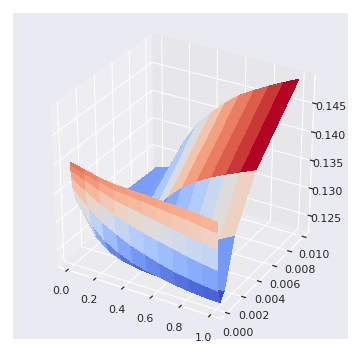

In [34]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z.T, rstride=1, cstride=1
                  , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False
                 )

In [35]:
minimum = cv.min().min()
row, col = np.where(cv==minimum)
best_l1_ratio, best_alpha  = cv.index.values[row][0], cv.columns.values[col][0]

print('With Elastic Net optimiized l1_ratio = ',best_l1_ratio,'\n',
      'optimazed alpha = ',best_alpha)

With Elastic Net optimiized l1_ratio =  1.0 
 optimazed alpha =  0.00046415888336127773


Text(0.5,1,'Coefficients of the Elastic Net Model')

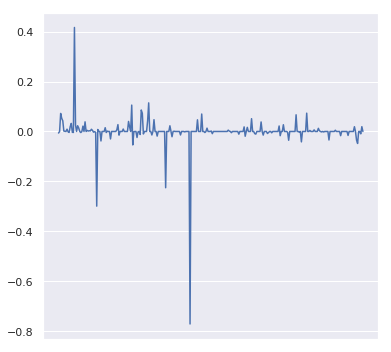

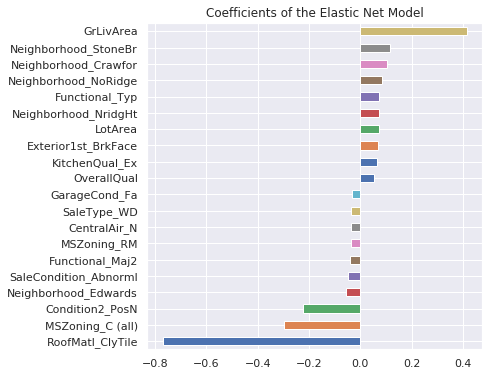

In [36]:
model_ElasticNet = ElasticNet(alpha=best_alpha, l1_ratio= best_l1_ratio)
model_ElasticNet.fit(X_train, y_log)

ElasticNet_coef = pd.Series(model_ElasticNet.coef_, index = X_train.columns)
plt.plot(ElasticNet_coef)
plt.xticks([])

imp_coef = pd.concat([ElasticNet_coef.sort_values().head(10),
                     ElasticNet_coef.sort_values().tail(10)])

plt.figure()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients of the Elastic Net Model")

Text(0.5,1,'Rediduals of Simple Regression')

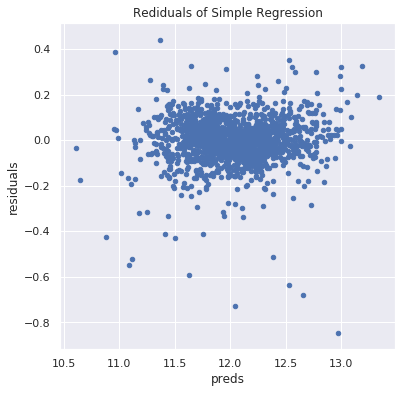

In [37]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ElasticNet.predict(X_train), "true":y_log})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title('Rediduals of Simple Regression')

## We see that with elastic net, the optimal model converges to Lasso in this case! 


# Train a ElasticNetCV for submission

# Trying out ElasticNetCV

In [38]:
l1_ratio = .7;#pick this value because Lasso has given a better score
a = 4*10**-4;
alphas = np.linspace(.9*a, 1.1*a,10)
cv_ElasticNet = [ rmse_cv(ElasticNetCV(l1_ratio=l1_ratio,alphas=alphas,cv=5), X_train,y_log,cv=5)]

print(cv_ElasticNet)

# cv = pd.Series(cv_ElasticNet, index= l1_ratios)
# sns.set()
# plt.plot(cv,'bo')
# cv[cv==cv.min()]


[array([0.10397473, 0.13206916, 0.12840517, 0.10509487, 0.14750869])]


In [39]:
np.mean(cv_ElasticNet)

0.12341052615275686

In [40]:
model_ElasticCV = ElasticNetCV(l1_ratio=l1_ratio,alphas=alphas,cv=5)
model_ElasticCV.fit(X_train, y_log)
y_hat = model_ElasticCV.predict(X_train)
error(np.exp(y_hat), y)

0.10130308143915898

In [41]:
#submit the prediction with Elastic Net
test_predictions = model_ElasticCV.predict(X_test)
test_predictions = np.exp(test_predictions)

submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = test_predictions
submission.to_csv('submission_ElasticNet.csv',index=False)

In [42]:
# y_hat = model_ElasticNetCV.predict(X_train)
# error(y_hat, y_log)

In [43]:
# #submit the prediction
# test_predictions = model_LassoCV.predict(X_test)
# test_predictions = np.exp(test_predictions)

# submission = pd.read_csv('../input/sample_submission.csv')
# submission.SalePrice = test_predictions
# submission.to_csv('submission_030619.csv',index=False)


In [44]:
# #For Neural Network with TensorFlow

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [45]:
# train_dataset = normed_X_train
# train_labels = train['SalePrice'] 
# def build_model():
#   model = keras.Sequential([
#     layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
#     layers.Dense(128, activation=tf.nn.relu),
#     layers.Dense(64, activation=tf.nn.relu),
#     layers.Dense(1)
#   ])

#   optimizer = tf.keras.optimizers.RMSprop(0.001)

#   model.compile(loss='mean_squared_logarithmic_error',
#                 optimizer=optimizer,
#                 metrics=['mean_squared_logarithmic_error'])
#   return model

# #build the model
# model = build_model()



# # Display training progress by printing a single dot for each completed epoch
# class PrintDot(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs):
#     if epoch % 100 == 0: print('')
#     print('.', end='')

# EPOCHS = 1500;

# #set earlystop when val_loss is not improving, patienece is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=75)

# history = model.fit(
#   normed_X_train.values, y.values,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[
#               early_stop,
#               PrintDot()])

In [46]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch

# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  

  
#   plt.figure(figsize=(12,8))
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error ')
#   plt.plot(hist['epoch'], hist['mean_squared_logarithmic_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_logarithmic_error'],
#            label = 'Val Error')
#   plt.ylim([0,.1])
#   plt.legend()


# plot_history(history)
# plt.ylim([0,1])
# #plt.hlines(.028, 0, 1500,'b')
# plt.show()
# hist.tail()

In [47]:
# train_predictions = model.predict(normed_X_train).flatten()

# plt.scatter(train_labels, train_predictions)
# plt.xlabel('True Values [SalePrice]')
# plt.ylabel('Predictions [SalePrice]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# plt.plot([0, 10**6], [0, 10**6])
# plt.plot(train['SalePrice'].mean(),train['SalePrice'].mean(),'ko')

# def error(actual, hat):
#     return np.sqrt(np.sum(np.square(np.log(actual)-np.log(hat)))/len(actual))
# print(error(train_predictions,y))

In [48]:
# error(y,.5*y_hat+.5*train_predictions)